In [23]:
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data
import pyro
import pyro.distributions as dist
import tyxe
from sklearn.datasets import make_moons
import pickle 
from collections import defaultdict
import seaborn as sns 
import numpy as np 

def rec_dd():
    return defaultdict(rec_dd)

import sys
sys.path.append("../psvi")

C1 = sns.xkcd_rgb["green"]
C2 = sns.xkcd_rgb["orange"]
C3 = sns.xkcd_rgb["blue"]
C4 = sns.xkcd_rgb["red"]
COLS = np.array([C1, C2, C3, C4])
UC1 = sns.xkcd_rgb["green"]
UC2 = sns.xkcd_rgb["orange"]
UC3 = sns.xkcd_rgb["blue"]
UC4 = sns.xkcd_rgb["red"]
UCOLS = np.array([UC1, UC2, UC3, UC4])
EXTENT = (-3, 4, -2, 3)
dnm = 'halfmoon'
n_test_per_dim = 250
title_font = {'size':'28'}

def make_grid(n_test_per_dim=n_test_per_dim):
    _x0_test = torch.linspace(-3, 4, n_test_per_dim)
    _x1_test = torch.linspace(-2, 3, n_test_per_dim)
    return torch.stack(torch.meshgrid(_x0_test, _x1_test), dim=-1)

coreset_sizes = 16
N = 1000
(X, Y) = make_moons(n_samples=N, noise=0.1, random_state=42)
X, Y = torch.from_numpy(X.astype(np.float32)), torch.from_numpy(
                Y[...,None].astype(np.float32)
            )
def set_up_TyXe_model():
    pyro.clear_param_store()
    net = nn.Sequential(nn.Linear(2, 100), nn.ReLU(), nn.Linear(100, 1))
    prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
    obs_model = tyxe.likelihoods.Bernoulli(N, event_dim=1)
    kernel = partial(pyro.infer.mcmc.HMC, step_size=1e-3, num_steps=50, target_accept_prob=0.7)
    return tyxe.bnn.MCMC_BNN(net, prior, obs_model, kernel)
    
def predictive_entropy(g):
    p = g[0,...]
    return -p*np.log(p) - (1-p)*np.log(1-p)

# VI on learnt coreset

In [21]:
! \
python3 ../experiments/flow_psvi.py \
--num_epochs 1001 \
--inner_it 50 \
--log_every 100 \
--lr0u 1e-2 \
--lr0v 1e-1 \
--lr0net 1e-4 \
--n_hidden 100 \
--datasets halfmoon \
--architecture fn \
--methods psvi_alpha_v \
--num_trials 1 \
--init_at subsample \
--init_sd 1e-3 \
--data_minibatch 128 \
--log_pseudodata \
--coreset_sizes "$coreset_sizes"\
--retrain_on_coreset \
--fnm mcmc

mcmc

Reading/Generating the dataset HALFMOON

Bayesian neural network experiment.
Inference via PSVI_ALPHA_V on halfmoon data over 1 trial.





Running psvi_alpha_v

Trial #0
Coreset/Subset with 16 datapoints
  0%|                                                  | 0/1001 [00:00<?, ?it/s]
logging predictive grid at 0
/home/dionm/.local/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

predictive accuracy: 50.50%
/home/dionm/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipp

/tmp/ipykernel_1945190/1857703377.py:59: RuntimeWarning: divide by zero encountered in log
  return -p*np.log(p) - (1-p)*np.log(1-p)
/tmp/ipykernel_1945190/1857703377.py:59: RuntimeWarning: invalid value encountered in multiply
  return -p*np.log(p) - (1-p)*np.log(1-p)


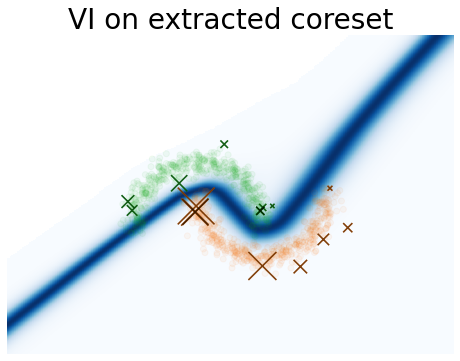

In [43]:
meth = 'psvi_alpha_v'
with open('../results/mcmc.pk', 'rb') as f:
       results = pickle.load(f)
us, zs, vs, gpreds = (
        results[dnm][meth][coreset_sizes][0]['us'],
        results[dnm][meth][coreset_sizes][0]['zs'],
        results[dnm][meth][coreset_sizes][0]['vs'],
        results[dnm][meth][coreset_sizes][0]['grid_preds'],
)

def plot_full(idx=-1, a0=0.05, a1=0.9, ax=None, fnm=None):
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(X[:, 0], X[:, 1], c=COLS[Y.squeeze().int().numpy()], alpha=a0)
    ax.scatter(us[idx][:, 0], us[idx][:, 1], c=UCOLS[torch.tensor(zs[idx]).squeeze().int().numpy()], alpha=a1, marker='x', s=5e3*vs[idx])
    ax.scatter(us[idx][:, 0], us[idx][:, 1], c='k', alpha=0.5, marker='x', s=5e3*vs[idx])
    ents = predictive_entropy(gpreds[idx]).reshape((250, 250)).T
    ax.imshow(ents, extent=EXTENT, origin="lower", cmap='Blues')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    plt.title('VI on extracted coreset',**title_font)
    plt.show()
    f.savefig(fnm + ".png",
        format="png",
        bbox_inches="tight",
    )

plot_full(idx=-1, fnm='figs/mcmc-vi-coreset')

# MCMC on learnt coreset

In [44]:
samples_from_coreset = torch.multinomial(torch.from_numpy(vs[-1]), N, replacement=True) # sample summarising data using coreset points weighting
learned_coreset_dataset = data.TensorDataset(torch.from_numpy(us[-1][samples_from_coreset].astype(np.float32)), 
                                            torch.from_numpy(zs[-1][samples_from_coreset][...,None].astype(np.float32)))
learned_coreset_loader = data.DataLoader(learned_coreset_dataset, batch_size=N)
bnn_coreset = set_up_TyXe_model()

bnn_coreset.fit(learned_coreset_loader, 100000, warmup_steps=20000)

x_test = make_grid()
preds = bnn_coreset.predict(x_test.view(-1,2), num_predictions=8, aggregate=True).sigmoid()

Warmup:   7%| | 7822/120000 [06:52, 18.97it/s, step size=5.39e-02, acc. prob=0.6
Sample: 100%|█| 120000/120000 [03:17, 606.72it/s, step size=3.36e-02, acc. prob=


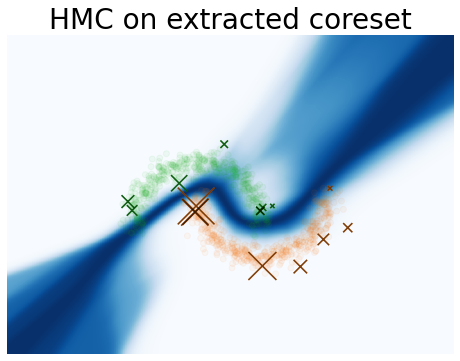

In [45]:
def plot_full(idx=-1, a0=0.05, a1=0.9, ax=None, fnm=None):
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(X[:, 0], X[:, 1], c=COLS[Y.squeeze().int().numpy()], alpha=a0)
    ax.scatter(us[idx][:, 0], us[idx][:, 1], c=UCOLS[torch.tensor(zs[idx]).squeeze().int().numpy()], alpha=a1, marker='x', s=5e3*vs[idx])
    ax.scatter(us[idx][:, 0], us[idx][:, 1], c='k', alpha=0.5, marker='x', s=5e3*vs[idx])
    ents = predictive_entropy(preds.squeeze().reshape((n_test_per_dim, n_test_per_dim, 1)).T)
    ax.imshow(ents, extent=EXTENT, origin="lower", cmap='Blues')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    plt.title('HMC on extracted coreset',**title_font)
    plt.show()
    f.savefig(fnm + ".png",
        format="png",
        bbox_inches="tight",
    )

plot_full(idx=-1, fnm='figs/mcmc-hmc-coreset')

# VI on full data

In [29]:
! \
python3 ../experiments/flow_psvi.py \
--num_epochs 5001 \
--log_every 1000 \
--lr0net 1e-4 \
--n_hidden 100 \
--datasets halfmoon \
--architecture fn \
--methods mfvi \
--num_trials 1 \
--init_sd 1e-3 \
--data_minibatch 128 \
--log_pseudodata \
--fnm full_data_vi

full_data_vi

Reading/Generating the dataset HALFMOON

Bayesian neural network experiment.
Inference via MFVI on halfmoon data over 1 trial.





Running mfvi

Trial #0
Unconstrained data access
  0%|                                                 | 0/10002 [00:00<?, ?it/s]/home/dionm/.local/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
predictive accuracy: 44.00%
100%|████████████████████████████████████▉| 9977/10002 [00:41<00:00, 250.98it/s]predictive accuracy: 99.50%
predictive accuracy: 99.50%
100%|████████████████████████████████████| 10002/10002 [00:41<00:00, 238.56it/s]
Trial completed!

Storing results in ../results/full_data_vi.pk


/tmp/ipykernel_1945190/1857703377.py:59: RuntimeWarning: divide by zero encountered in log
  return -p*np.log(p) - (1-p)*np.log(1-p)
/tmp/ipykernel_1945190/1857703377.py:59: RuntimeWarning: invalid value encountered in multiply
  return -p*np.log(p) - (1-p)*np.log(1-p)


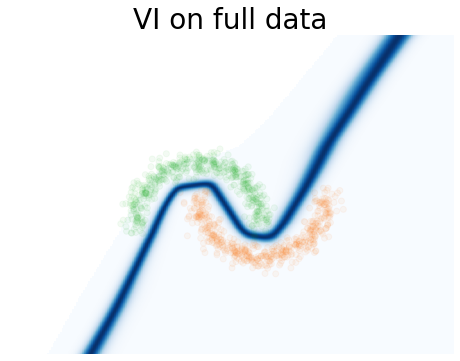

In [31]:
meth = 'mfvi'
with open('../results/full_data_vi.pk', 'rb') as f:
       results = pickle.load(f)
gpreds = (
        results[dnm][meth][-1][0]['grid_preds'],
)
def plot_full(idx=-1, a0=0.05, a1=0.9, ax=None, fnm=None):
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(X[:, 0], X[:, 1], c=COLS[Y.squeeze().int().numpy()], alpha=a0)
    ents = predictive_entropy(gpreds[idx][-1]).reshape((250, 250)).T
    ax.imshow(ents, extent=EXTENT, origin="lower", cmap='Blues')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    plt.title('VI on full data',**title_font)
    plt.show()
    f.savefig(fnm + ".png",
        format="png",
        bbox_inches="tight",
    )

plot_full(fnm='figs/mcmc-vi-full')

# MCMC on full dataset

Sample: 100%|█| 120000/120000 [03:17, 608.71it/s, step size=6.34e-02, acc. prob=


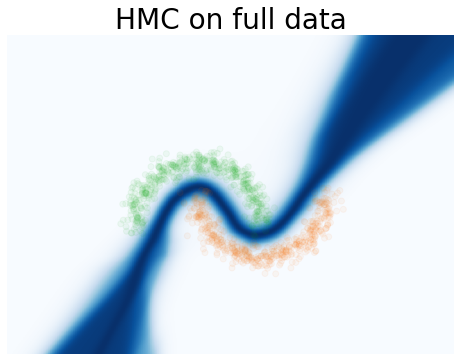

In [32]:
hm_dataset = data.TensorDataset(X, Y)
hm_loader = data.DataLoader(hm_dataset, batch_size=N)
bnn_full = set_up_TyXe_model()

bnn_full.fit(hm_loader, 100000, warmup_steps=20000)

x_test = make_grid()
preds = bnn_full.predict(x_test.view(-1,2), num_predictions=8, aggregate=True).sigmoid()

def plot_preds(a0=0.05, ax=None, fnm=None):
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(X[:, 0], X[:, 1], c=COLS[Y.squeeze().int().numpy()], alpha=a0)
    ents = predictive_entropy(preds.squeeze().reshape((n_test_per_dim, n_test_per_dim, 1)).T)
    ax.imshow(ents, extent=EXTENT, origin="lower", cmap='Blues')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    plt.title('HMC on full data',**title_font)
    plt.show()
    f.savefig(fnm + ".png",
        format="png",
        bbox_inches="tight",
    )

plot_preds(fnm='figs/mcmc-hmc-full')

# VI on random coreset

In [33]:
! \
python3 ../experiments/flow_psvi.py \
--num_epochs 5001 \
--log_every 1000 \
--lr0net 1e-4 \
--n_hidden 100 \
--coreset_sizes "$coreset_sizes" \
--datasets halfmoon \
--architecture fn \
--methods mfvi_subset \
--num_trials 1 \
--init_sd 1e-3 \
--data_minibatch 128 \
--log_pseudodata \
--fnm random_coreset

random_coreset

Reading/Generating the dataset HALFMOON

Bayesian neural network experiment.
Inference via MFVI_SUBSET on halfmoon data over 1 trial.





Running mfvi_subset

Trial #0
Coreset/Subset with 16 datapoints
  0%|                                                 | 0/10002 [00:00<?, ?it/s]/home/dionm/.local/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
predictive accuracy: 44.50%
100%|████████████████████████████████████| 10002/10002 [00:35<00:00, 277.89it/s]
Trial completed!

Storing results in ../results/random_coreset.pk


torch.Size([16, 2]) torch.Size([16]) (16,)


/tmp/ipykernel_1945190/1857703377.py:59: RuntimeWarning: divide by zero encountered in log
  return -p*np.log(p) - (1-p)*np.log(1-p)
/tmp/ipykernel_1945190/1857703377.py:59: RuntimeWarning: invalid value encountered in multiply
  return -p*np.log(p) - (1-p)*np.log(1-p)


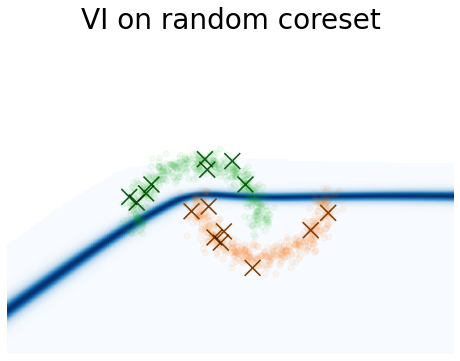

In [38]:
meth = 'mfvi_subset'
with open('../results/random_coreset.pk', 'rb') as f:
       results = pickle.load(f)
us, zs, vs, gpreds = (
        results[dnm][meth][coreset_sizes][0]['us'],
        results[dnm][meth][coreset_sizes][0]['zs'],
        results[dnm][meth][coreset_sizes][0]['vs'],
        results[dnm][meth][coreset_sizes][0]['grid_preds'],
)

def plot_full(idx=-1, a0=0.05, a1=0.9, ax=None, fnm=None):
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(X[:, 0], X[:, 1], c=COLS[Y.squeeze().int().numpy()], alpha=a0)
    print(us.shape, zs.shape, np.asarray(vs).shape)
    ax.scatter(us[:, 0], us[:, 1], c=UCOLS[zs.detach().int().numpy()], alpha=a1, marker='x', s=5*np.asarray(vs))
    ax.scatter(us[:, 0], us[:, 1], c='k', alpha=0.5, marker='x', s=5*np.asarray(vs))
    ents = predictive_entropy(gpreds[idx]).reshape((250, 250)).T
    ax.imshow(ents, extent=EXTENT, origin="lower", cmap='Blues')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    plt.title('VI on random coreset',**title_font)
    plt.show()
    f.savefig(fnm + ".png",
        format="png",
        bbox_inches="tight",
    )


plot_full(fnm='figs/mcmc-vi-random')

# MCMC on random coreset

In [ ]:
samples_from_coreset = torch.multinomial(torch.from_numpy(np.asarray(vs)), N, replacement=True) # sample summarising data using coreset points weighting
random_coreset_dataset = data.TensorDataset(us[samples_from_coreset], 
                                            zs[samples_from_coreset][...,None])
random_coreset_loader = data.DataLoader(random_coreset_dataset, batch_size=N)
bnn_random = set_up_TyXe_model()
bnn_random.fit(random_coreset_loader, 100000, warmup_steps=20000)

x_test = make_grid()
preds = bnn_random.predict(x_test.view(-1,2), num_predictions=8, aggregate=True).sigmoid()

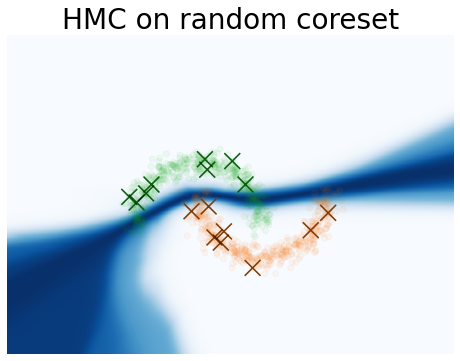

In [41]:
def plot_full(idx=0, a0=0.05, a1=0.9, ax=None, fnm=None):
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(X[:, 0], X[:, 1], c=COLS[Y.squeeze().int().numpy()], alpha=a0)
    ax.scatter(us[:, 0], us[:, 1], c=UCOLS[zs.detach().int().numpy()], alpha=a1, marker='x', s=5*np.asarray(vs))
    ax.scatter(us[:, 0], us[:, 1], c='k', alpha=0.5, marker='x', s=5*np.asarray(vs))
    ents = predictive_entropy(preds.squeeze().reshape((n_test_per_dim, n_test_per_dim, 1)).T)
    ax.imshow(ents, extent=EXTENT, origin="lower", cmap='Blues')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    plt.title('HMC on random coreset',**title_font)
    plt.show()
    f.savefig(fnm + ".png",
        format="png",
        bbox_inches="tight",
    )


plot_full(idx=-1, fnm='figs/mcmc-hmc-random')